# TP Coding Convolutional Neural Networks in Pytorch - part 1

For any remark or suggestion, please feel free to contact me at:

- alasdair.newson@telecom-paris.fr

### Objective:

We want to implement a Convolutional Neural Network (CNN) for image recognition. For this we will use two well-known datasets, the first simpler and the second more complicated :

- MNIST (images of digits)
- CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

We will first code the simple ConvNet described below using the Pytorch environment : https://pytorch.org/.

- In general, the input of a classification CNN is a set of (c,m,n) image tensors, where are the image sizes, and c is the number of channels of the image. For mnist, the number of channels is c=1, and for CIFAR10, it is c=3.
- For the first case of mnist images, we apply the following layers: 
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we apply zero-padding)
    - additive biases
    - a ReLu activation function
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we apply zero-padding)
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)

Here is a visual example of the above architecture, with c=3:

<IMG SRC='https://perso.telecom-paristech.fr/anewson/doc/ima_205/images/TP_ima_CNN.png'>
        
### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE)

# Load packages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

### CNN model in Pytorch

There are several ways to write a CNN model in pytorch. In this lab, you will be using the _Sequential_ class of pytorch (similarly to Tensorflow). We will see the syntax further on.



## Import data

We first import MNIST dataset. We use the ```torch.utils.data.DataLoader``` function of Pytorch to easily iterate over mini-batches of data.

In [3]:
# convert input to Pytorch tensors
input_transform=transforms.Compose( [transforms.ToTensor()])
# extract mnist data
mnist_trainset = datasets.MNIST(root='./data',train=True,download=True,transform=input_transform)
print(mnist_trainset)

#create data loader with smaller dataset size
max_mnist_size = 1000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0] 
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset_reduced, batch_size=256, shuffle=True)

# download test dataset
mnist_testset = datasets.MNIST(root='./data',train=False,download=True,transform=input_transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=256, shuffle=True)

# extract the actual data and labels
X_train = torch.unsqueeze(mnist_trainset.data,axis=1)[0:max_mnist_size]/255.0
Y_train = mnist_trainset.targets[0:max_mnist_size]
X_test = torch.unsqueeze(mnist_testset.data,axis=1)/255.0
Y_test = mnist_testset.targets


100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 31200628.61it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 14417483.20it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 16018537.41it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


### Exploring the data

The mnist data is downloaded into ```mnist_trainset```. We can explore the dataset manually, although when we will train it, we will use the ```DataLoader``` of Pytorch. ```torch.utils.data.DataLoader``` is a useful function to extract batches of data from a dataset, applying the transformations which we have specified (conversion to Pytorch tensor, normalisation etc).

The images are contained in a sub-structure of ```mnist_trainset``` called ```data```. The labels are contained in another sub-structure of ```mnist_trainset``` called ```targets```. Note that these are kept in their native format (the transformations are not applied to them), so to use them we have to apply the transformation manually, as above.

__NOTE__ In general, if you want to find out what a structure contains, use the command ```dir()```, this will give you a list of the sub-structures.

In [4]:
print(dir(mnist_trainset))

print("Size of training data : ", mnist_trainset.data.shape)
print("Size of training labels : ", mnist_trainset.targets.shape)


['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']
Size of training data :  torch.Size([60000, 28, 28])
Size of training labels :  torch.Size([60000])


The mnist dataset has 10 classes. These are the following :

In [5]:
mnist_list = [ '0', '1','2','3','4','5','6','7','8','9']

### Display some of the images

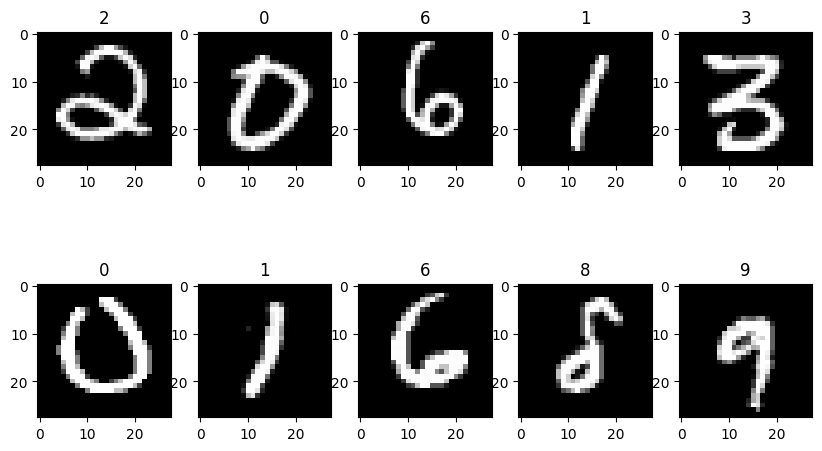

In [6]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,mnist_trainset.data.shape[0])
    plt.imshow(mnist_trainset.data[rand_ind,:,:],cmap='gray')
    plt.title(mnist_list[int(mnist_trainset.targets[rand_ind])])

## Defining the model for MNIST

We will now define the simple CNN described above, for use with MNIST. The input of the CNN is a set of (28,28,1) image tensors. We apply the following layers:

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data: reduce them to a vector in order to be able to apply a Fully-Connected layer to it
    - Dense (fully connected) layer. Note, you will have to determine the input size, that is to say the number of elements after the last Max Pooling layer.

__VERY IMPORTANT NOTE !!!__

Pytorch carries out the softmax which we would expect at the end of our network automatically, so there is no need to add it. Nevertheless, you must understand that the output is a vector which is _not_ normalised to be a probability distributuion. This will be important later on.

Now, we define the following hyper-parameters of the model :

In [7]:

learning_rate = 0.01
n_epochs = 10
batch_size = 64
nb_classes = int(mnist_trainset.targets.max()+1)

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1 #greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

# 1. Model 1 : defining a CNN with the Sequential API of Pytorch for MNIST

We are now going to create the CNN with Pytorch.

The Sequential approach is quite similar to that of Tensorflow. To define a model, just write:

```my_model = torch.nn.Sequential( first_layer, second_layer, ...)```

Each layer must be a function imported from the Pytorch. You can use the following functions:

- ```torch.nn.Conv2d()```
- ```torch.nn.ReLU()```
- ```torch.nn.MaxPool2d()```
- ```torch.nn.Flatten()```
- ```torch.nn.Linear()```

Look at the documentation online to find the correct parameters. For example:

- https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html


In [ ]:
# BEGIN STUDENT CODE
convLayer1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same")
reLULayer1 = torch.nn.reLU(convLayer1)
convLayer2 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same")
reLULayer2 = torch.nn.reLU(convLayer1)
mnist_model = torch.nn.Sequential()
# END STUDENT CODE

### Define loss function and optimiser

Pytorch provides an easy way to define the loss criterion to optimise. The syntax is (considering that the Adam optimiser is used):

- ```criterion = torch.nn.BCELoss()``` or ```criterion = torch.nn.CrossEntropyLoss()```, etc., depending on your problem.
- ```optimizer = torch.optim.Adam(mnist_model.parameters(), lr=learning_rate)```

Fill in the following code, choosing the correct criterion to optimise.

In [ ]:
# BEGIN STUDENT CODE 
criterion = ...
optimizer = ...
# END STUDENT CODE

### CNN prediction conversion

We recall here that the output of the classification CNN in Pytorch is a vector which is __NOT__ normalised to be a probability distribution. Therefore, for the purposes of finding the prediction of the CNN, we create a function which first converts an input vector to a probability distribution, and then determines the most likely class for each vector. The output should be, for each vector, an integer between 0 and (number of classes) $-1$.

The inputs to this function will be Pytorch tensors, so you can use the following Pytorch functions on them :

- ```torch.nn.Softmax()```
- ```torch.argmax()```

Create this function now.

In [ ]:
def vector_to_class(x):
  # BEGIN STUDENT CODE
  y = ...
  # END STUDENT CODE
  return y

### Accuracy

Now, define a function which calcualtes the accuracy of the output of the neural network, with respect to the input labels. We consider that the input is a vector of class numbers (the final prediction of the CNN).

In [ ]:
def cnn_accuracy(predict,labels):
  # BEGIN STUDENT CODE
  accuracy = ...
  # END STUDENT CODE
  return accuracy

## Training the model

Now, we carry out the actual training of the model.

In [ ]:

train_losses=[]
valid_losses=[]

for epoch in range(0,n_epochs):
  train_loss=0.0

  for batch_idx, (imgs, labels) in enumerate(mnist_train_loader):

    # set the gradients back to 0
    optimizer.zero_grad()
    predict=... # FILL IN STUDENT
    # apply loss function
    loss=criterion(predict,labels)
    # backpropagation
    loss.backward()
    optimizer.step()
    train_loss=loss.item()
  print('Epoch:{} Train Loss:{:.4f}'.format(epoch,train_loss/imgs.shape[0]))
  # calculate accuracy

  print('Accuracy:{:.4f}'.format(cnn_accuracy(vector_to_class(predict),labels)))

In [ ]:

# Calculate accuracy on the training set and the test set

# BEGIN FILL IN STUDENT (use X_train, Y_train, X_test, Y_test)
predict_train = ...
predict_test = ...


train_accuracy = cnn_accuracy(...,...)
test_accuracy = cnn_accuracy(...,...)
# END FILL IN STUDENT
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


    

In [ ]:
print("Visual results : ")

plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    test_img = torch.unsqueeze(X_test[rand_ind,:,:,:],axis=1)
    predicted_class = vector_to_class(mnist_model(test_img))
    plt.imshow(test_img.squeeze(),cmap='gray')
    plt.title(mnist_list[int(predicted_class)])

## Model 2: create a CNN on CIFAR10

We are now going to train the same network architecture on a more difficult dataset : CIFAR10

First, we import the CIFAR10 data and carry out some pre-processing :

In [ ]:
# convert input to Pytorch tensors
input_transform=transforms.Compose( [transforms.ToTensor()])
# extract mnist data
cifar_trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=input_transform)
print(cifar_trainset)

#create data loader with smaller dataset size
max_cifar_size = 2000
cifar_trainset_reduced = torch.utils.data.random_split(cifar_trainset, [max_cifar_size, len(cifar_trainset)-max_cifar_size])[0] 
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset_reduced, batch_size=256, shuffle=True)

# download test dataset
cifar_testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=input_transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=256, shuffle=True)

# extract the actual data and labels
X_train = cifar_trainset.data[0:max_cifar_size]/255.0
Y_train = cifar_trainset.targets[0:max_cifar_size]
X_test = cifar_testset.data/255.0
Y_test = cifar_testset.targets

nb_channels = X_train.shape[-1]


In [ ]:
# the CIFAR10 categories
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

#modify the number of input channels 
n_h_0 = nb_channels
# add more epochs
n_epochs = 30

### Display some of the images

In [ ]:
plt.figure(figsize=(10, 6))
for idx in range(0,10):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    plt.imshow(X_test[rand_ind,:,:,:])
    plt.title(cifar_10_list[int(Y_test[rand_ind])])

## Define the architecture again, for CIFAR10

In this case, we are going to add a layer because the data is more complex. Therefore, we use the following architecture :

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same'
    - additive biases
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - Dense (fully connected) layer. Note, you will have to determine the input size, that is to say the number of elements after the last Max Pooling layer.
    - ReLU activation function
    - Dense (fully connected) layer

In [ ]:

learning_rate = 0.01
n_epochs = 50
batch_size = 64

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)


# --- Size of the successive layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters

Now, modify the previous code (you can copy/paste/modify the necessary parts) to define the model for CIFAR10.

In [ ]:
# BEGIN STUDENT CODE

cifar_model = torch.nn.Sequential(...)

criterion = ...
optimizer = ...
# END STUDENT CODE

Now, carry out training on the CIFAR10 dataset (use the previous code as an example).

In [ ]:

# BEGIN STUDENT CODE
# END STUDENT CODE

 What do you think about the results (better or worse than MNIST) ? Why do you think this is ? How could you improve the results ?

## Visualising the convolutional weights

You can explore the network parameters easily with Pytroch. Indeed, your model ```cifar_model``` is simply a list of layers, thus you can access the first layer with :
- ```cifar_model[0]```

If you want to find out the contents of this layer, use :

```dir(cifar_model[0])```

In particular, the convolutional weights are contained in the ```weights``` sub-structure (a multi-dimensional array). Note that this weight's size is : 

- $[n_{filters}, y_{size}, x_{size},n_{channels}]$

Now, display all (32) trained filters of the first convolutional layer, taking only the first channel of each filter :

In [ ]:

plt.figure(figsize=(10, 6))
for num in range(0,32):
    plt.subplot(8, 4, num+1)
    # --- START CODE HERE
    plt.imshow( (...).detach().numpy(),cmap='gray')
    # --- END CODE HERE    

What do you think ? Pretty incomprehensible no ? Do not spend too long trying to interpret these filters, that way madness lies. Indeed, they say that you can find some researchers locked in their offices staring at convolutional filters, trying to find some semblance of meaning ...

So, it seems that understanding a CNN by just looking at the filters is an exercise in futility. How can we do better ? Well, take a look at part 2 of the lab !